---

# CreditCard

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

from load_data import get_CreditCard

In [2]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

In [3]:
def plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, real_scores, fake_scores, i, DATASET, show = False):
    num_epochs = len(d_losses)
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), d_losses[:num_epochs], label='d loss')
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    

    plt.plot(range(1, num_epochs + 1), d_losses_val[:num_epochs], '--', label='d loss val')

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_losses_{DATASET}.pdf')
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.plot(range(1, num_epochs + 1), g_losses[:num_epochs], label='g loss')    
    plt.plot(range(1, num_epochs + 1), bce_losses[:num_epochs], label=r'$\log(D(y))$')    
    plt.plot(range(1, num_epochs + 1), rec_losses[:num_epochs], label=r'MSE')    

    plt.yscale('log')
    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_gen_loss_{DATASET}.pdf')  
    
    plt.figure()
    plt.xlim(0, num_epochs + 1)
    plt.ylim(0, 1)
    plt.plot(range(1, num_epochs + 1), fake_scores[:num_epochs], label='fake score')
    plt.plot(range(1, num_epochs + 1), real_scores[:num_epochs], label='real score')    

    plt.legend(loc = 'lower right', bbox_to_anchor=(.8, 0.3, 0.5, 0.5))
    
    if show:
        plt.show()
    else:
        plt.savefig(f'./images/{i}_score_{DATASET}.pdf') 
        
def generate_labels(size,pflip,lb,ub,step,decay=.9995,up=True): #decay=.99995
    
    if up:
        lb = ub - (ub-lb)*((decay)**step)
    else:
        ub = lb + (ub-lb)*((decay)**step)
    pflip = pflip*((decay)**step)
    
    y = np.random.uniform(lb, ub,size)   

    sf = int(pflip*size)    
    if sf > 0:
        y[:sf] = 1- y[:sf]
        np.random.shuffle(y)
    
    return torch.FloatTensor(y)



class Generator(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Generator, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), 
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.nf_out, self.nf_out * 2),
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.nf_out * 2, self.nf_in)
        )

        self.sigmoid = nn.Sigmoid()

        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        enc = self.encoder(x)
        logits = self.decoder(enc)
        sampled_data = self.sigmoid(logits)
        return logits, sampled_data
    
class Discriminator(nn.Module):

    def __init__(self, nc = 121, nf_out = 16, nout = 128):
        super(Discriminator, self).__init__()
        
        self.nc = nc
        self.nf_out = nf_out
        self.nout = nout
        
        self.main = nn.Sequential(
            # features extractor
            nn.Linear(self.nc, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout, self.nout * 2),
            nn.BatchNorm1d(self.nout * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),

            nn.Linear(self.nout * 2, self.nout * 4),
            nn.BatchNorm1d(self.nout * 4, track_running_stats = False),
            nn.LeakyReLU(0.2),

            # classifier
            nn.Linear(self.nout * 4, self.nout),
            nn.BatchNorm1d(self.nout, track_running_stats = False),
            nn.ReLU(),

            nn.Linear(self.nout, self.nf_out * 4),
            nn.BatchNorm1d(self.nf_out * 4, track_running_stats = False),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 4, self.nf_out * 2),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out * 2, self.nf_out),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.Linear(self.nf_out, 1),
            nn.Sigmoid()
        )
        
        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    
    def forward(self, x):
        x = self.main(x)
        return x.flatten()
    

class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        
    def forward(self, true_preds, fake_preds, step):
        
        bs = true_preds.size(0)
        y_real = generate_labels(bs,0.3,0.7,1., step, up=True).to(device)
    
        D_real_loss = self.criterion(true_preds, y_real)
    
        y_fake = generate_labels(bs,0.3,0.,0.3, step, up=False).to(device)

        D_fake_loss = self.criterion(fake_preds, y_fake)

        return D_real_loss + D_fake_loss
    
    
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        
        self.criterion = nn.BCELoss() 
        self.mse = nn.MSELoss(reduction = 'mean')
        self.cel = nn.CrossEntropyLoss()

    def forward(self, true_data, fake_preds, sampled_data, beta = 1, gamma = 1e-2):
        
        bs = fake_preds.size(0)
                
        y_fake = torch.ones(bs).to(device)
        log_p_y = self.criterion(fake_preds, y_fake)
        
        rec = self.mse(true_data, sampled_data)
        
        return gamma*log_p_y + rec, log_p_y, rec
    
    
    
class AADNet(nn.Module):
    def __init__(self, device, nc):
        super(AADNet, self).__init__()
        self.device = device
        self.nc = nc

        self.D = Discriminator(nc = self.nc).to(self.device)
        self.G = Generator(nf_in = self.nc).to(self.device)

        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=1e-4)
        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=1e-3)
        
        self.d_loss = DiscriminatorLoss()
        self.g_loss = GeneratorLoss()
        
        self.criterion = nn.BCELoss()
        
        
    def D_step(self,true_data, step):
        self.D.zero_grad()

        logits, sampled_data = self.G(true_data)
        true_pred = self.D(true_data)
        fake_pred = self.D(sampled_data.detach())

        d_loss_batch = self.d_loss(true_pred, fake_pred, step)
        d_loss_batch.backward()
        self.d_optimizer.step()

        return d_loss_batch, true_pred, fake_pred

    
    def G_step(self,true_data, step):
        self.G.zero_grad()
        
        logits, sampled_data = self.G(true_data)    
        fake_pred = self.D(sampled_data)

        gen_loss_batch, bce_loss, rec_loss = self.g_loss(true_data, fake_pred, sampled_data)
        gen_loss_batch.backward()

        self.g_optimizer.step()

        return gen_loss_batch, bce_loss, rec_loss
            
            
    def evaluation(self, test_loader):
        self.D.eval()
        
        d_l = []
        ind = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
                d_loss_batch = self.criterion(y_pred, label)
                
            d_l.append(d_loss_batch.item())
        
        return np.mean(d_l)
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
    def predict(self, test_loader):
        self.D.eval()
        i = 0
        
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                y_pred = self.D(batch)
                
            if i == 0:
                prediction = y_pred.cpu().round()
                y_true = label.cpu()
                yP = y_pred.cpu()
            else:
                prediction = torch.cat((prediction, y_pred.cpu().round()))
                y_true = torch.cat((y_true, label.cpu()))
                yP = torch.cat((yP, y_pred.cpu()))
                
            i += 1
            
        return prediction, y_true, yP
        
        
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15, num_q_steps = 1, num_g_steps = 1):
        
        d_losses = np.zeros(num_epochs)
        g_losses = np.zeros(num_epochs)
        real_scores = np.zeros(num_epochs)
        fake_scores = np.zeros(num_epochs)
        rec_losses = np.zeros(num_epochs)
        bce_losses = np.zeros(num_epochs)
        
        d_losses_val = np.zeros(num_epochs)
        precision_abn = np.zeros(num_epochs)
        recall_abn = np.zeros(num_epochs)
        
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            step_count = 0
            for epoch in range(num_epochs):
                self.D.train()
                self.G.train()
                i = 0
                for batch in data_loader:
                    
                    step_count += 1
                    batch = batch.to(self.device)

                    ### Train autoencoder ###
                    for _ in range(num_q_steps):
                        d_loss, real_score, fake_score = self.D_step(batch,step_count)

                    ### Train Generator ###
                    for _ in range(num_g_steps):
                        g_loss, bce_loss, rec_loss = self.G_step(batch, step_count)

                    d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) + d_loss.item()*(1./(i+1.))
                    g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) + g_loss.item()*(1./(i+1.))
                    
                    rec_losses[epoch] = rec_losses[epoch]*(i/(i+1.)) + rec_loss.item()*(1./(i+1.)) 
                    bce_losses[epoch] = bce_losses[epoch]*(i/(i+1.)) + bce_loss.item()*(1./(i+1.)) 
                    
                    real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().item()*(1./(i+1.))
                    fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().item()*(1./(i+1.))

                    
                    i += 1
                
                dLossVal = self.evaluation(test_loader)
                
                d_losses_val[epoch] = dLossVal
               
                sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | d_loss: {:.4f} | g_loss: {:.4f} ({:.2f}, {:.2f}) | D(x): {:.2f} | D(G(x)): {:.2f} | d_loss_val: {:.4f}'
                              .format(epoch+1, num_epochs, d_losses[epoch], g_losses[epoch], bce_loss.item(), rec_losses[epoch], real_scores[epoch], fake_scores[epoch], d_losses_val[epoch]))
                sys.stdout.flush()
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        return d_losses[:epoch], g_losses[:epoch],rec_losses[:epoch], bce_losses[:epoch], real_scores[:epoch], fake_scores[:epoch], d_losses_val[:epoch]
    

In [4]:
batch_size = 1024

WORK_SPACE = '../Dataset'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
DATASET = 'CreditCard'
FILE = 'creditcard.csv'

PATH = os.path.join(WORK_SPACE, DATASET, FILE)

In [5]:
dataset = get_CreditCard(PATH, seed, show=True)

284315 normal records, 492 anormal records
-----------------------------------------------------------------------------------------
There are 227846 records in training set
Training set is composed by 227846 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 14240 records in validation set
Validation set is composed by 14117 normal records and 123 abnormal records
-----------------------------------------------------------------------------------------
There are 42721 records in test set
Test set is composed by 42352 normal records and 369 abnormal records


#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0008 | g_loss: 0.1415 (14.09, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2005
[INFO] Training phase... Elapsed time: 1217 seconds



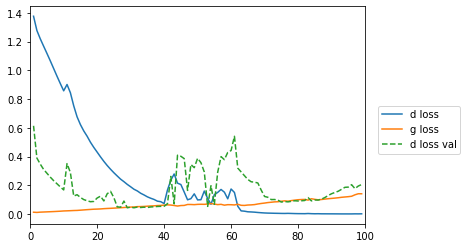

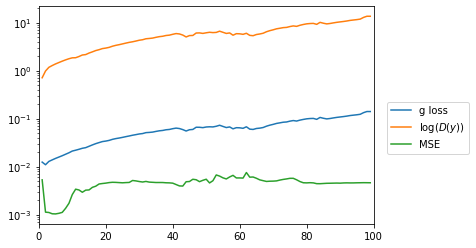

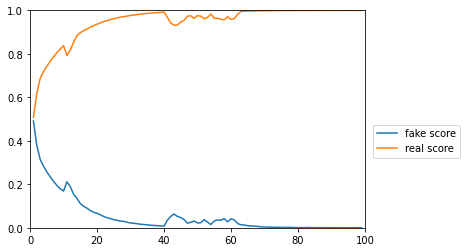

PR AUC: 0.47


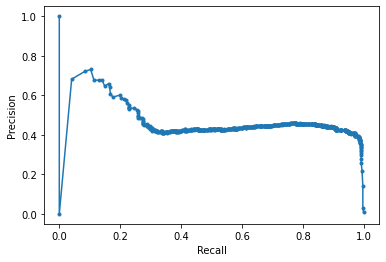

AUC: 0.99
Iteration: 2
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0020 | g_loss: 0.1093 (10.45, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3463
[INFO] Training phase... Elapsed time: 1206 seconds



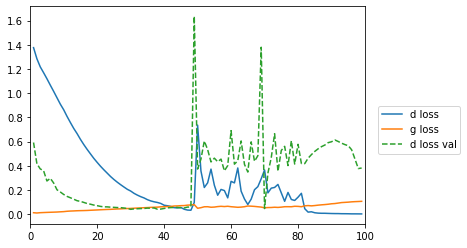

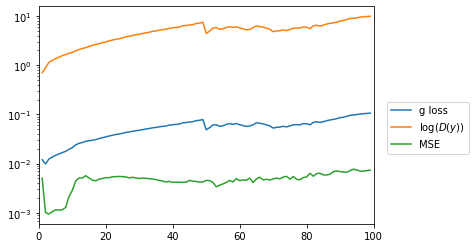

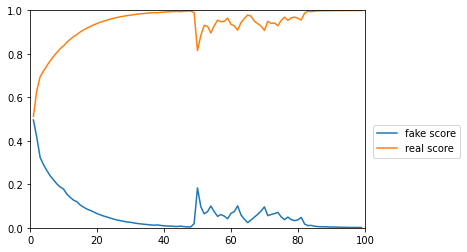

PR AUC: 0.51


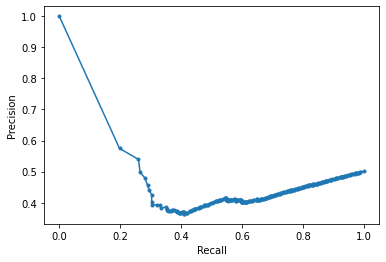

AUC: 0.99
Iteration: 3
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0006 | g_loss: 0.1267 (12.31, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1726
[INFO] Training phase... Elapsed time: 1219 seconds



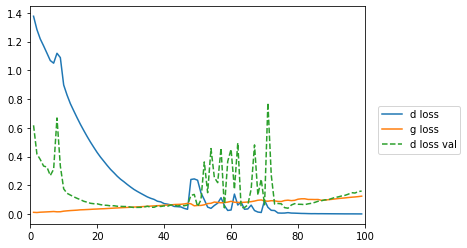

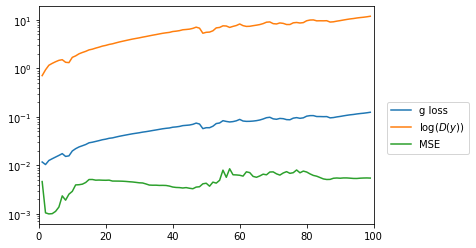

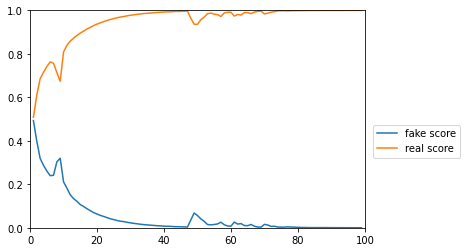

PR AUC: 0.53


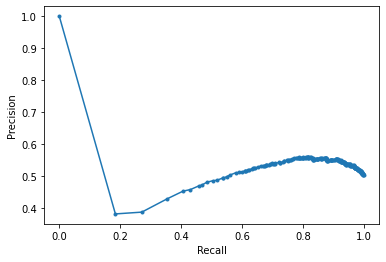

AUC: 1.00
Iteration: 4
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0007 | g_loss: 0.1447 (14.03, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1552
[INFO] Training phase... Elapsed time: 1227 seconds



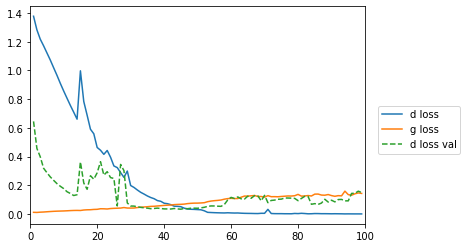

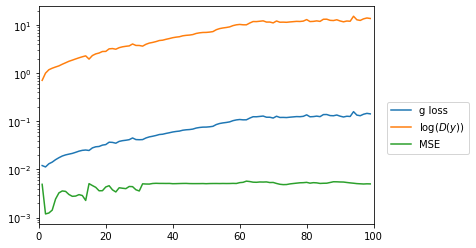

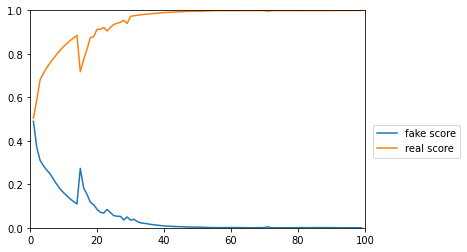

PR AUC: 0.69


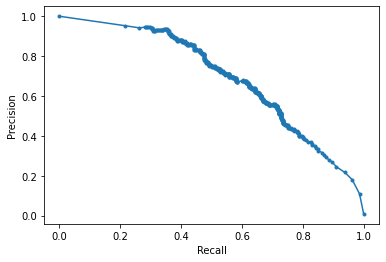

AUC: 0.99
Iteration: 5
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0025 | g_loss: 0.1572 (15.31, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2616
[INFO] Training phase... Elapsed time: 1223 seconds



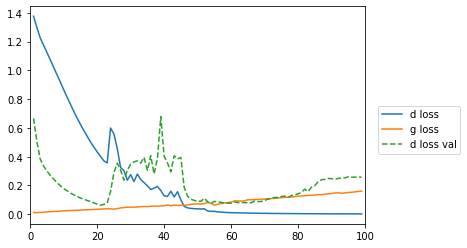

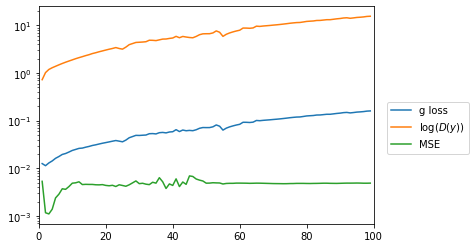

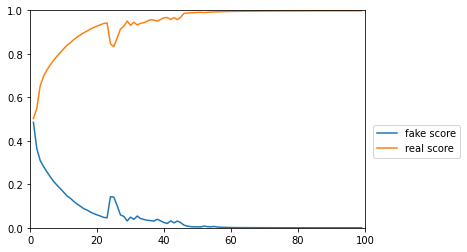

PR AUC: 0.11


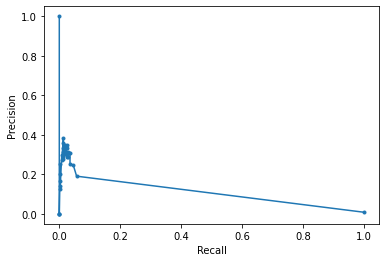

AUC: 0.53
Iteration: 6
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0002 | g_loss: 0.1711 (16.46, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2369
[INFO] Training phase... Elapsed time: 1228 seconds



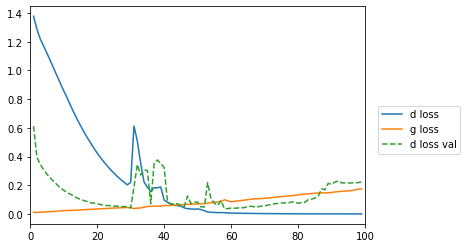

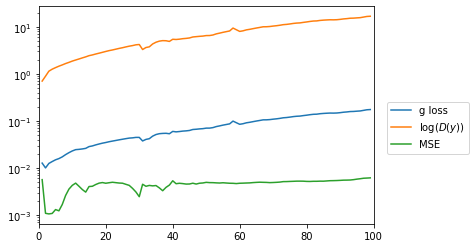

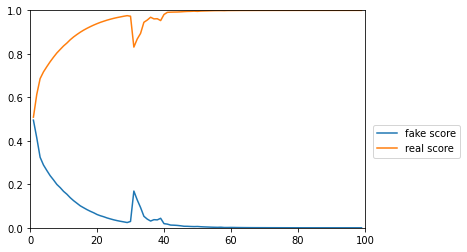

PR AUC: 0.17


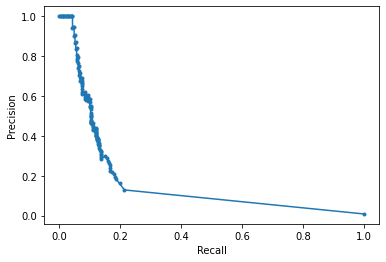

AUC: 0.60
Iteration: 7
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0031 | g_loss: 0.1147 (9.40, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.83890
[INFO] Training phase... Elapsed time: 1241 seconds



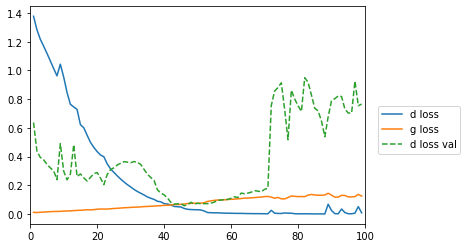

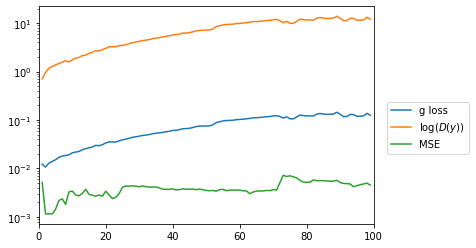

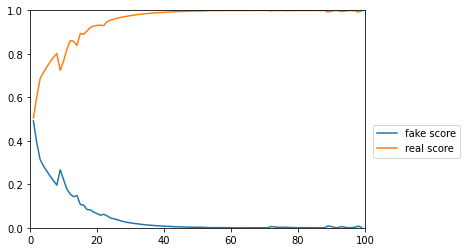

PR AUC: 0.85


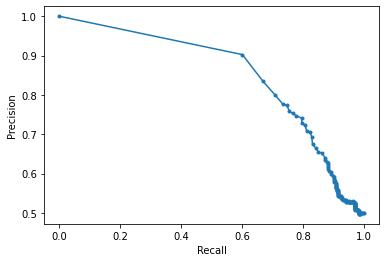

AUC: 1.00
Iteration: 8
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0006 | g_loss: 0.1554 (15.75, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1316
[INFO] Training phase... Elapsed time: 1339 seconds



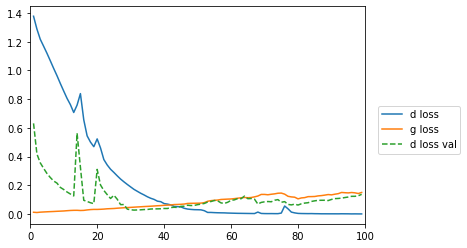

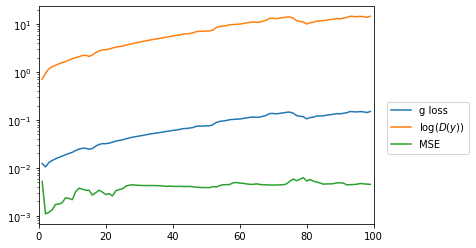

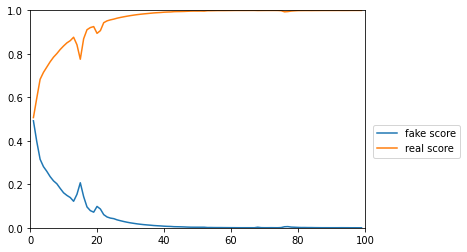

PR AUC: 0.30


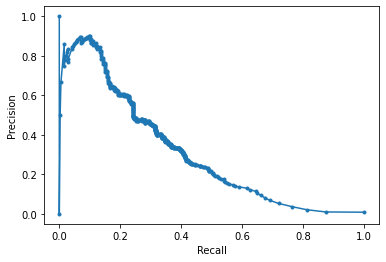

AUC: 0.83
Iteration: 9
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0013 | g_loss: 0.1534 (15.19, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.3029
[INFO] Training phase... Elapsed time: 1336 seconds



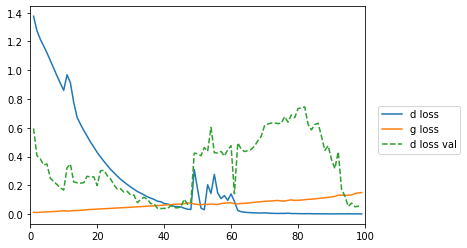

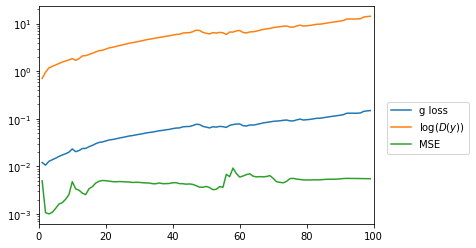

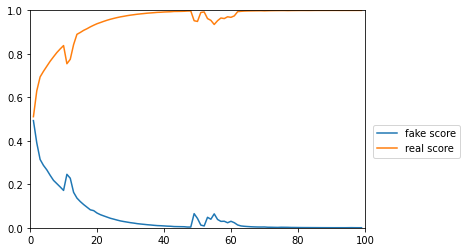

PR AUC: 0.69


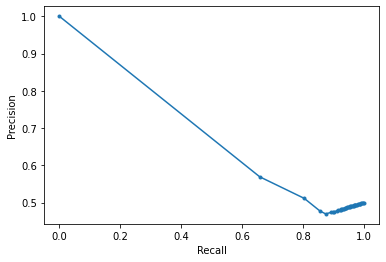

AUC: 1.00
Iteration: 10
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0016 | g_loss: 0.1682 (16.43, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1416
[INFO] Training phase... Elapsed time: 1339 seconds



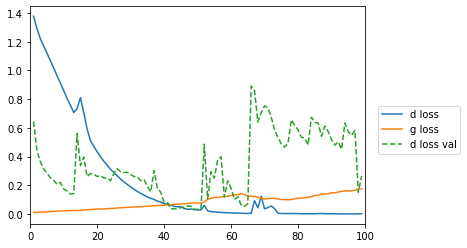

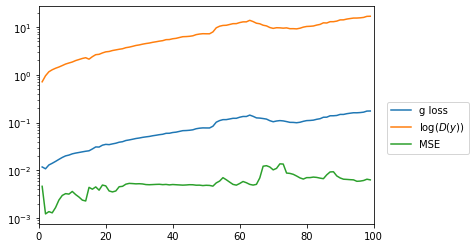

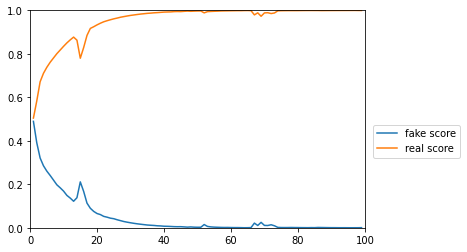

PR AUC: 0.62


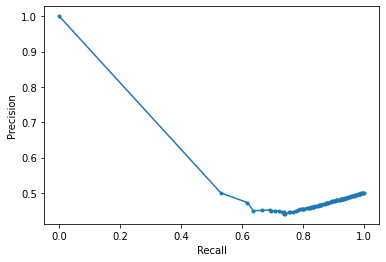

AUC: 1.00
Iteration: 11
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0022 | g_loss: 0.1292 (11.45, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.5246
[INFO] Training phase... Elapsed time: 1336 seconds



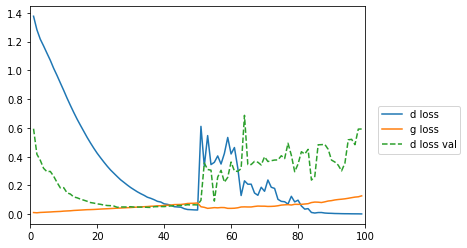

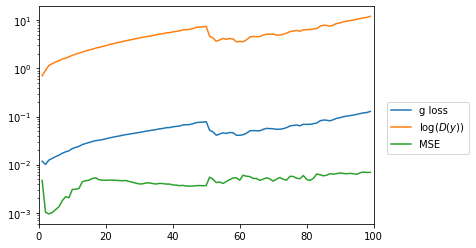

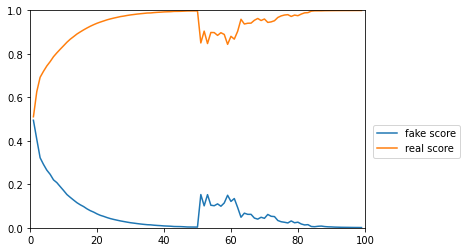

PR AUC: 0.51


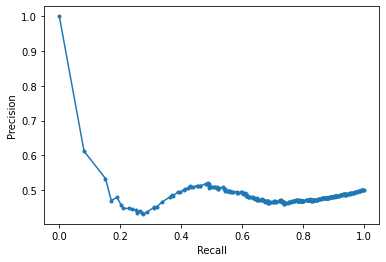

AUC: 1.00
Iteration: 12
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0012 | g_loss: 0.1502 (16.81, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1751
[INFO] Training phase... Elapsed time: 1331 seconds



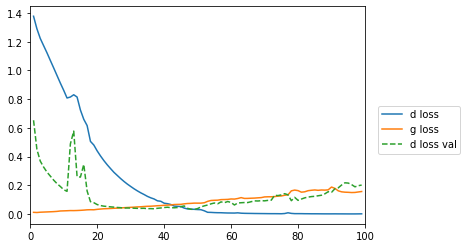

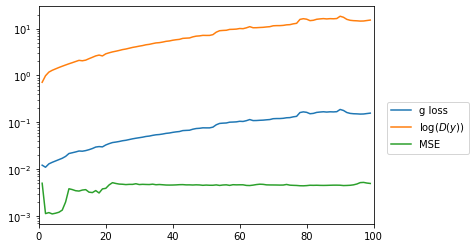

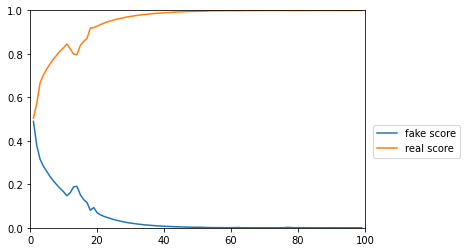

PR AUC: 0.53


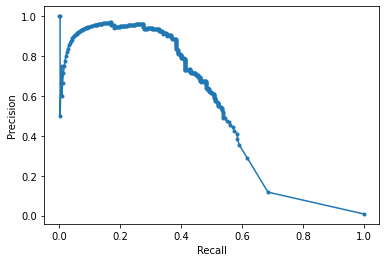

AUC: 0.83
Iteration: 13
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0002 | g_loss: 0.1802 (17.65, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2540
[INFO] Training phase... Elapsed time: 1333 seconds



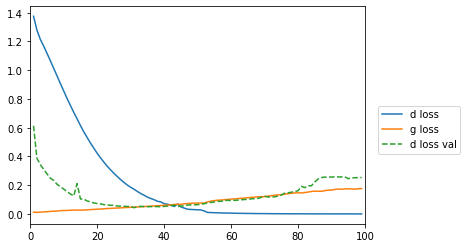

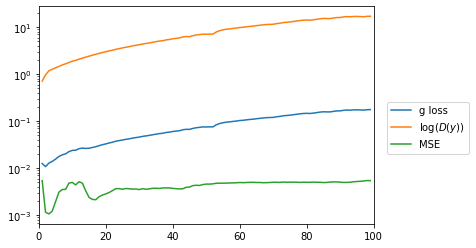

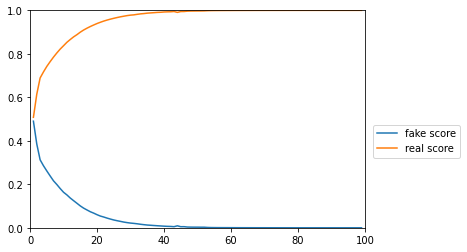

PR AUC: 0.04


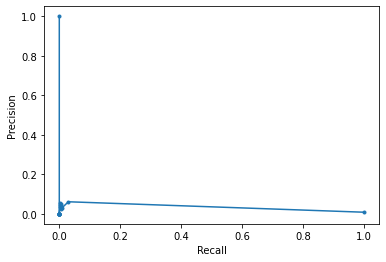

AUC: 0.51
Iteration: 14
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0032 | g_loss: 0.1277 (13.26, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.0923
[INFO] Training phase... Elapsed time: 1329 seconds



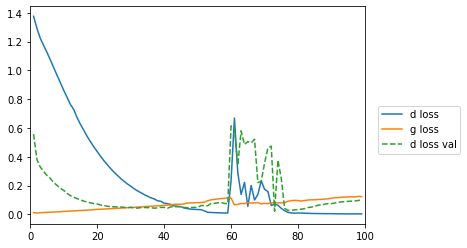

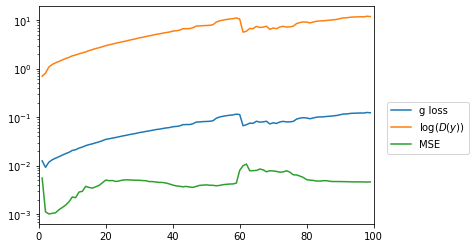

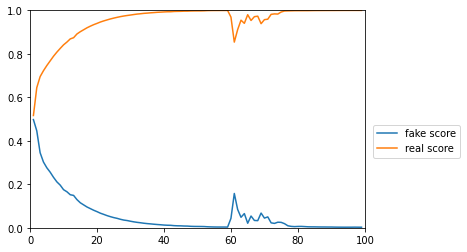

PR AUC: 0.57


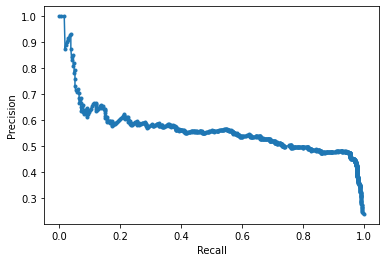

AUC: 1.00
Iteration: 15
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0007 | g_loss: 0.1301 (12.75, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1244
[INFO] Training phase... Elapsed time: 1248 seconds



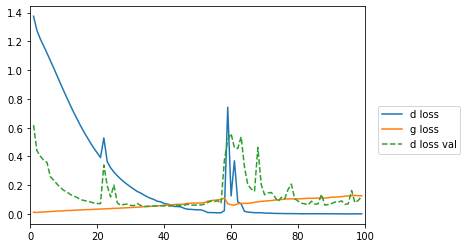

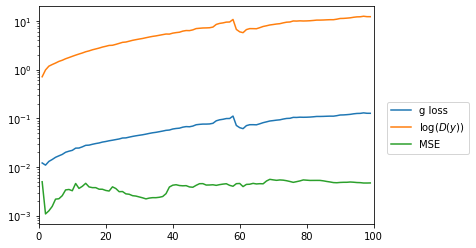

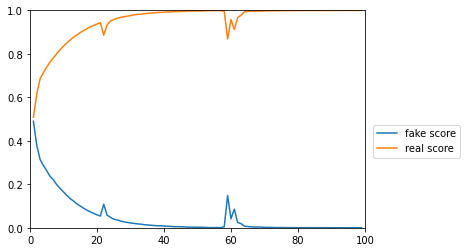

PR AUC: 0.63


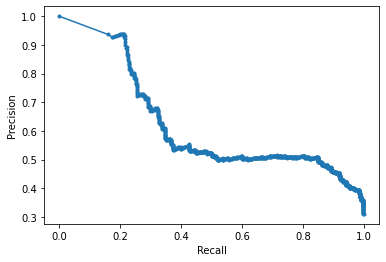

AUC: 1.00
Iteration: 16
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0003 | g_loss: 0.1500 (14.67, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2302
[INFO] Training phase... Elapsed time: 1082 seconds



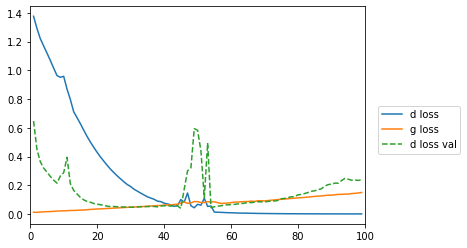

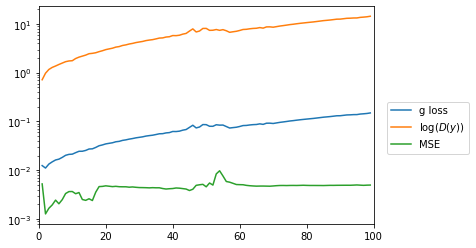

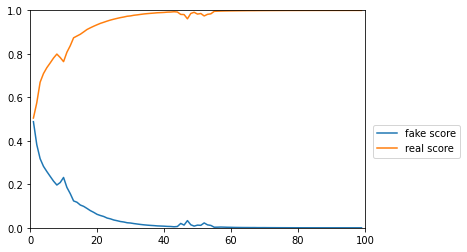

PR AUC: 0.58


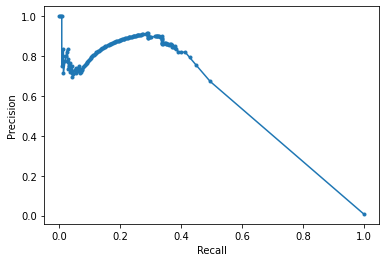

AUC: 0.75
Iteration: 17
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0006 | g_loss: 0.1531 (14.75, 0.00) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2533
[INFO] Training phase... Elapsed time: 1071 seconds



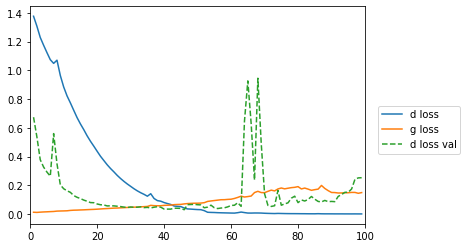

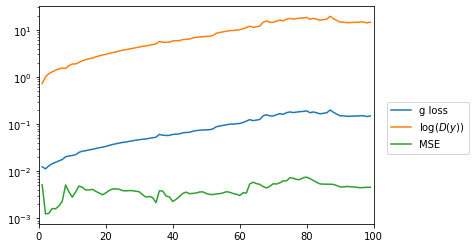

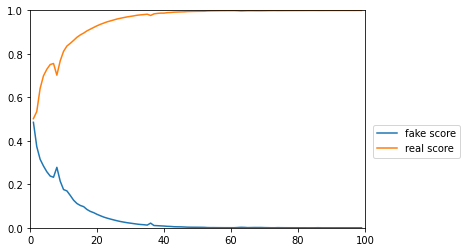

PR AUC: 0.12


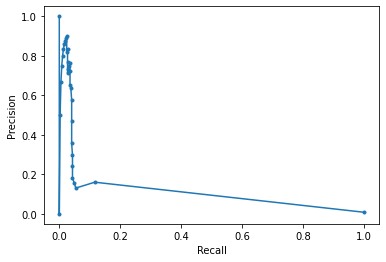

AUC: 0.56
Iteration: 18
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0003 | g_loss: 0.1971 (19.51, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.2543
[INFO] Training phase... Elapsed time: 1076 seconds



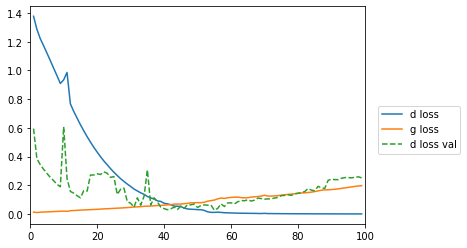

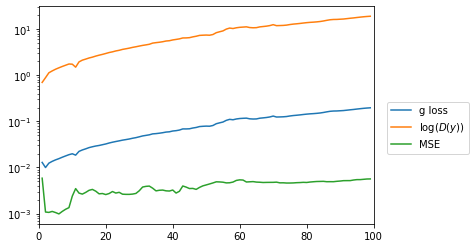

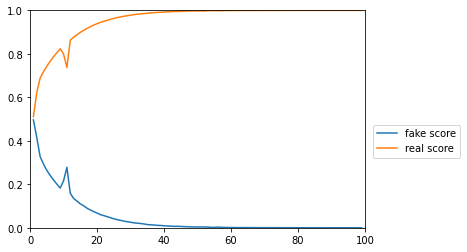

PR AUC: 0.17


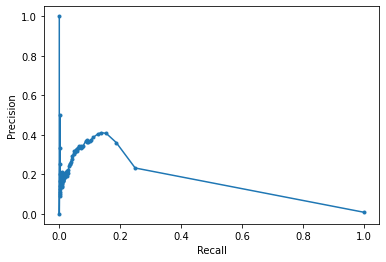

AUC: 0.62
Iteration: 19
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0144 | g_loss: 0.1565 (15.02, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 1.0534
[INFO] Training phase... Elapsed time: 1076 seconds



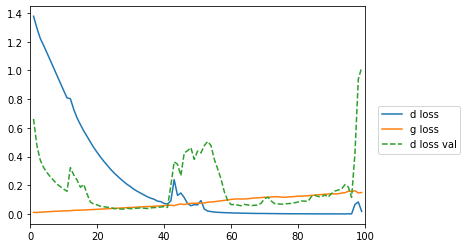

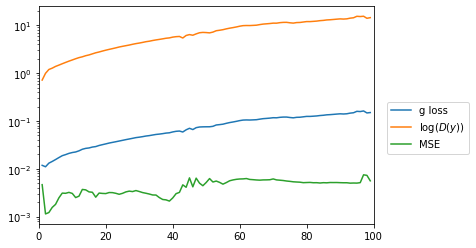

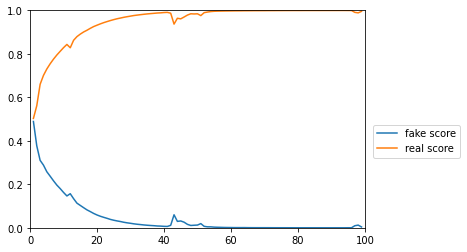

PR AUC: 0.82


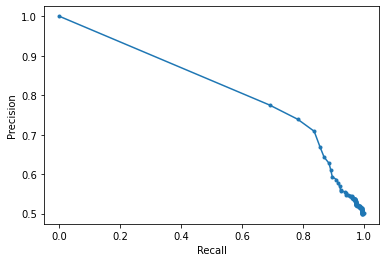

AUC: 1.00
Iteration: 20
[INFO] Starting training phase...
Epoch [100/100] | d_loss: 0.0006 | g_loss: 0.1301 (12.61, 0.01) | D(x): 1.00 | D(G(x)): 0.00 | d_loss_val: 0.1173
[INFO] Training phase... Elapsed time: 1076 seconds



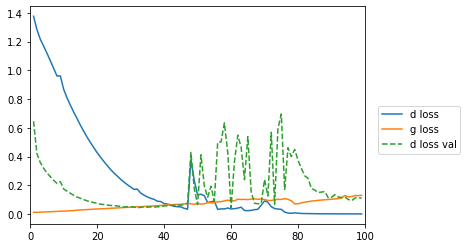

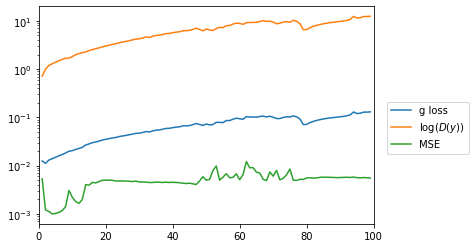

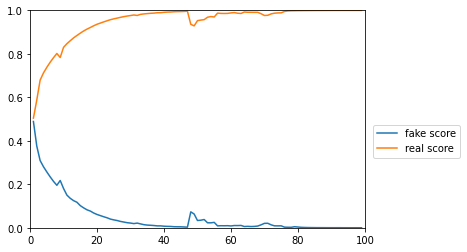

PR AUC: 0.59


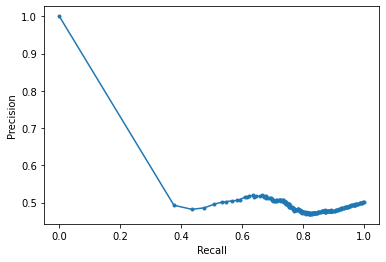

AUC: 1.00


In [6]:
n_runs = 20
auc_list = []
num_epochs = 100
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CreditCard(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = AADNet(device, dataset['x_train'].shape[1])
    
    d_losses, g_losses, rec_losses, bce_losses, real_scores, fake_scores, d_losses_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save models
    NAME_D = f'D_GCN_NOV_{DATASET}_{i}.ckpt'
    NAME_G = f'G_GCN_NOV_{DATASET}_{i}.ckpt'
    
    plotLoss(d_losses, g_losses, d_losses_val, bce_losses, rec_losses, real_scores, fake_scores, i, DATASET, show = True)
    
    prediction, y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(1-y_true, 1-yP)
    pr = trainer.pr_auc(1-y_true, 1-yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [7]:
meanAUC_PRAUC(auc_list, pr_list, 'GCN_NOV_CreditCard', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.992691238892933, 0.9944567685665523, 0.9956812782379808, 0.986620808902649, 0.5274224194593665, 0.6015383524632375, 0.9984084541685991, 0.8261309205696893, 0.9961360421830513, 0.9952160202325484, 0.9953239042921218, 0.8328311861462023, 0.5129038869487675, 0.9957383236941549, 0.9957411711678508, 0.7472019251737664, 0.5556253346581445, 0.6213884115371188, 0.9981096933891516, 0.9955078063011458]
**************
PR AUC:
[0.47317598823072093, 0.5064247481125227, 0.5279991781172005, 0.6946815581178178, 0.10920665733679465, 0.17022122564416653, 0.8522356212770724, 0.30474732754050116, 0.6905279524284722, 0.6178752914183281, 0.512499652172116, 0.5256941776505094, 0.035251612988393376, 0.5651828442917018, 0.626840299488958, 0.5823996691804292, 0.11594524269293396, 0.17163766262051144, 0.8177251225020511, 0.5888405387419586]
**************
AUC
0.86 +/- 0.08
95% confidence level, average auc would be between 0.78 and 0.94
**************
PR AUC
0.47 +/- 0.10
95% confidence level, average au

---